**Importing Libraries**

In [11]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import torchvision.transforms as T

**Helper Functions**

In [12]:
# Define the helper function
def decode_segmap(image, source, bgimg, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
    
  rgb = np.stack([r, g, b], axis=2)
  
  # Load the foreground input image 
  foreground = cv2.imread(source)

  # Load the background input image 
  background = cv2.imread(bgimg)

  # Change the color of foreground image to RGB 
  # and resize images to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))
  background = cv2.resize(background,(r.shape[1],r.shape[0]))
  

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)  
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)  
  
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)

  # Return a normalized output image for display
  return outImage/255

In [16]:
def segment(net, path, bgimagepath, show_orig=True, dev='cuda'):
  img = Image.open(path)
  
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show(); plt.imshow(Image.open(bgimagepath)); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(400), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  rgb = decode_segmap(om, path, bgimagepath)
    
  plt.imshow(rgb); plt.axis('off'); plt.show()

**Downloading various pretrained models from torchvision and making predictions**

In [14]:
fcn_resnet50 = models.segmentation.fcn_resnet50(pretrained=1).eval()

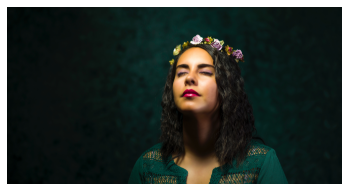

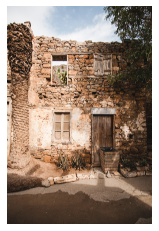

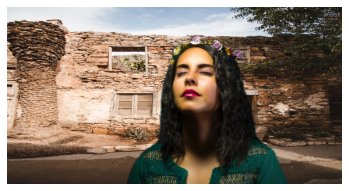

In [21]:
segment(fcn_resnet50, '/content/girl.png','/content/background-building.png')

In [6]:
fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


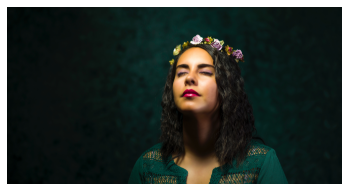

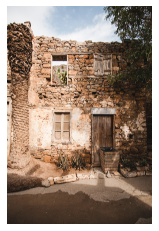

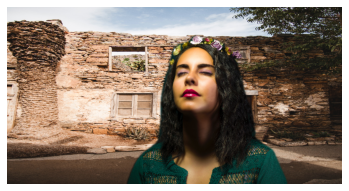

In [20]:
segment(fcn_resnet101, '/content/girl.png','/content/background-building.png')

In [7]:
deeplabv3_resnet50 = models.segmentation.deeplabv3_resnet50(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


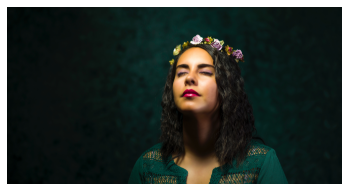

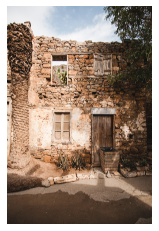

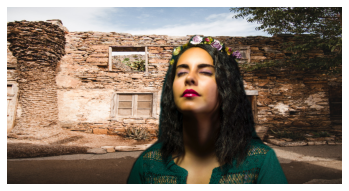

In [22]:
segment(deeplabv3_resnet50, '/content/girl.png','/content/background-building.png')

In [8]:
deeplabv3_resnet101 = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


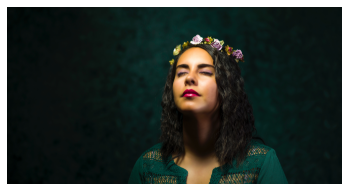

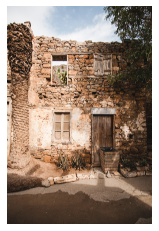

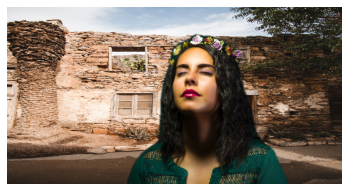

In [23]:
segment(deeplabv3_resnet101, '/content/girl.png','/content/background-building.png')

In [9]:
deeplabv3_mobilenet_v3_large = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


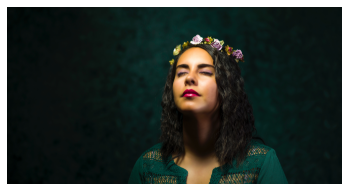

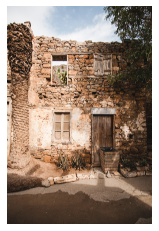

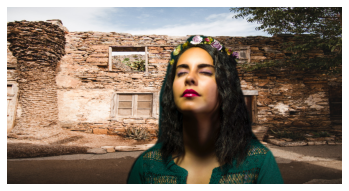

In [24]:
segment(deeplabv3_mobilenet_v3_large, '/content/girl.png','/content/background-building.png')

In [10]:
lraspp_mobilenet_v3_large = models.segmentation.lraspp_mobilenet_v3_large(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth


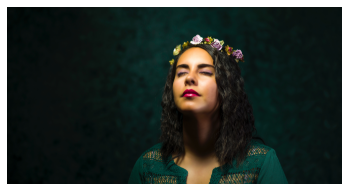

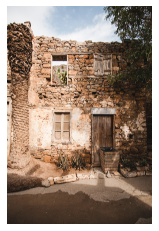

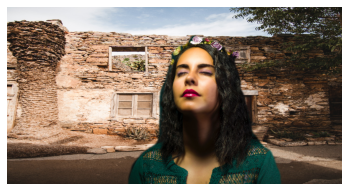

In [25]:
segment(lraspp_mobilenet_v3_large, '/content/girl.png','/content/background-building.png')